In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch.nn as nn
import torch.optim as optim
import torch

from dataloaders import create_data_loaders, create_datasets
from utils import save_model, save_plots, save_cf, SaveBestModel
from models import CNN

c:\Users\manki\miniconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Remove between this and
import sys
sys.path.append('../../ect/ect')
# This line. My ect setup is a bit different so I need this to run it.

from ect import ECT, EmbeddedGraph

In [3]:
# Parameters required to define the model. 
# Will remain same throught the excerise.
 
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float
# loss function
lossfcn = nn.CrossEntropyLoss()

# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Functions required for training.
def train(model, train_loader, optimizer, lossfcn, log_level='INFO'):
    model.train()

    log_level = log_level == True or str(log_level).upper() == 'INFO'
    if log_level:
        print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data in train_loader:
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

# function for validation
def validate(model, valid_loader, lossfcn, log_level='INFO'):
    model.eval()
    if log_level:
        print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for data in valid_loader:
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

In [5]:
# Function to generate the ect dataset.
def generate_ect_dataset(num_dirs,num_thresh, in_path, out_path='example_data/ect_output/', in_memory=False, log_level='INFO'):
    global_bound_radius = 2.9092515639765497

    log_level = log_level == True or str(log_level).upper() == 'INFO'

    # To avoid re-calculating the ECT for the same parameters.
    # Check previously saved settings.
    setting_path = os.path.join(out_path, '.ect_settings')
    if os.path.exists(setting_path):
        f = open(os.path.join(setting_path), 'r').readlines()
        settings = {}
        for line in f:
            key, value = line.strip().split('=')
            settings[key] = float(value)
        if settings['num_dirs'] == num_dirs and settings['num_thresh'] == num_thresh and settings['global_bound_radius'] == global_bound_radius:
            if log_level:
                print('ECT parameters match the saved settings. Skipping ECT calculation.')
            return            

    data = {}
    for path, subdirs, files in os.walk(in_path):
        # '.' prefix is used as a hidden file in unix systems.
        # We ignore these files because they may not be valid data files.
        files = [f for f in files if not f.startswith('.')]
        
        # Skip the directories that do not contain any files.
        if len(files) == 0:
            continue
        
        # Extracting the class name from the path.
        class_name = os.path.basename(path)
        data[ class_name ] = []
        if log_level:
            print(f'Processing {class_name} class.\nFound {len(files)} files.')
        
        # Looping through the files of each directory.
        for fname in files:
            file_path = os.path.join(path, fname)
            
            # The data is saved in numpy format as x,y coordinates of the leaf outline.
            G = EmbeddedGraph()
            leaf = np.load(file_path)
            
            # Create nodes for each point in the leaf outline.
            for i, (x,y) in enumerate(leaf):
                G.add_node(i,x,y)
            
            # Connect the nodes to form the outline.
            for i in range( len(leaf)-1 ):
                G.add_edge(i, i+1)

            ect = ECT(num_dirs = num_dirs, num_thresh = num_thresh)
            
            # This will change with the dataset.
            ect.set_bounding_radius(global_bound_radius)
            ect.calculateECT(G)

            if in_memory:
                data[ class_name ].append( ect.get_ECT() )
            else:
                os.makedirs(
                    os.path.join(out_path, class_name),
                    exist_ok=True
                    )
                output_filedir = os.path.join(out_path, class_name, fname)
                np.save(output_filedir, ect.get_ECT())
    
    # Save the ect output parameters if in_memory is False.
    if not in_memory:
        with open(os.path.join(out_path, '.ect_settings'), 'w') as f:
            f.write(f'num_dirs={num_dirs}\nnum_thresh={num_thresh}\nglobal_bound_radius={global_bound_radius}')

    # Note the syntax of inline if-else statement.
    # value_if_true if condition else value_if_false
    return data if in_memory else None

    # Notice how I have extra code after return statement.
    # This code will never be executed but it's not good practice to have code after return statements.
    # It is useful when testing code if your function takes long time to run.
    # You can put a return statement where you want to test the code.

    # You can also write it as:
    if in_memory:
        return data
    else:
        return None
    
    # Functions always return None if there is no return statement.
    # So you could skip the else part:
    if in_memory:
        return data

In [9]:
def ect_train_validate(
        num_dirs, num_thresh, input_path, output_path="example_data/ect_output", in_memory=False,
        num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
        batch_size=4, valid_split=0.2, num_workers=0,
        log_level='INFO'
):
    data = generate_ect_dataset(
        num_dirs, num_thresh, input_path, in_memory=in_memory, out_path=output_path, log_level=log_level
    )
    data = data if in_memory else output_path
    
    log_level = log_level == True or str(log_level).upper() == 'INFO'

    train_dataset, test_dataset = create_datasets(data, valid_split, log_level)
    train_loader, test_loader = create_data_loaders(train_dataset, test_dataset, batch_size, num_workers)
    trainimages, trainlabels = next(iter(train_loader))
    
    model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)

    save_best_model = SaveBestModel(log_level=log_level)
    train_loss, valid_loss = [],[]
    train_acc, valid_acc = [],[]

    # begin training
    for epoch in range(1,num_epochs+1):
        if log_level:
            print(f"[INFO]: Epoch {epoch} of {num_epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn, log_level)
        valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn, log_level)
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        if log_level:
            print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
            print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

        # save the best model up to current epoch, if we have the least loss in the current epoch
        save_best_model(
            valid_epoch_loss, epoch, model, optimizer, lossfcn
        )
        if log_level:
            print('-'*50)
    output = {
        "num_epochs": num_epochs,
        "model": model,
        "optimizer": optimizer,
        "lossfcn": lossfcn,
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_acc": train_acc,
        "valid_acc": valid_acc,
        "train_loader": train_loader,
        "test_loader": test_loader,
        "train_dataset": train_dataset,
        "test_dataset": test_dataset
    }
    return output

In [10]:
# model, valid_loader, lossfcn
def report_trained_model(
        num_dirs, num_thresh,
        train_dataset, train_loader, test_loader, test_dataset 
):
    trainimages, trainlabels = next(iter(train_loader))
    model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh))

    state_dict = torch.load('outputs/best_model.pth')['model_state_dict']
    model.load_state_dict(state_dict)
    model.eval()
    model = model.to(device)
    print('Using validation to compute confusion matrix')
    valid_running_pred = []
    valid_running_labels = []
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)

            valid_running_pred.append(preds)
            valid_running_labels.append(labels)
        
    # confusion matrix for the complete epoch
    valid_running_pred = torch.cat(valid_running_pred)
    valid_running_labels = torch.cat(valid_running_labels)
    print('classes:',test_dataset.classes)
    save_cf(valid_running_pred.cpu(),valid_running_labels.cpu(), test_dataset.classes)

Saving final model...


C:\Users\manki\AppData\Local\Temp\ipykernel_22128\3478529572.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pth')['model_sta

Using validation to compute confusion matrix


100%|██████████| 3/3 [00:00<00:00, 300.04it/s]


classes: ['Cotton', 'Ivy']
Test Result:
Accuracy Score: 91.67%
_______________________________________________
CLASSIFICATION REPORT:
                  0         1  accuracy  macro avg  weighted avg
precision  1.000000  0.833333  0.916667   0.916667      0.930556
recall     0.857143  1.000000  0.916667   0.928571      0.916667
f1-score   0.923077  0.909091  0.916667   0.916084      0.917249
support    7.000000  5.000000  0.916667  12.000000     12.000000
_______________________________________________
Confusion Matrix: 
 [[6 1]
 [0 5]]



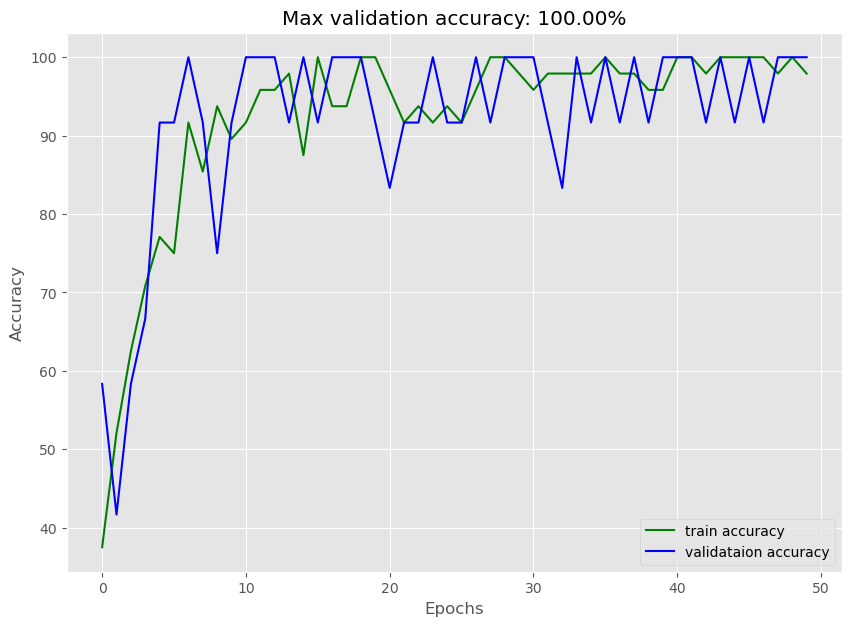

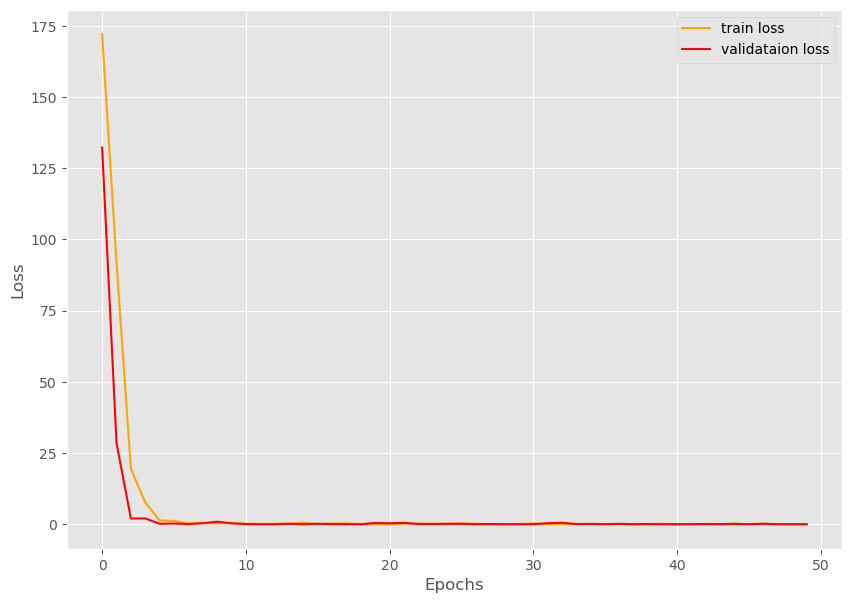

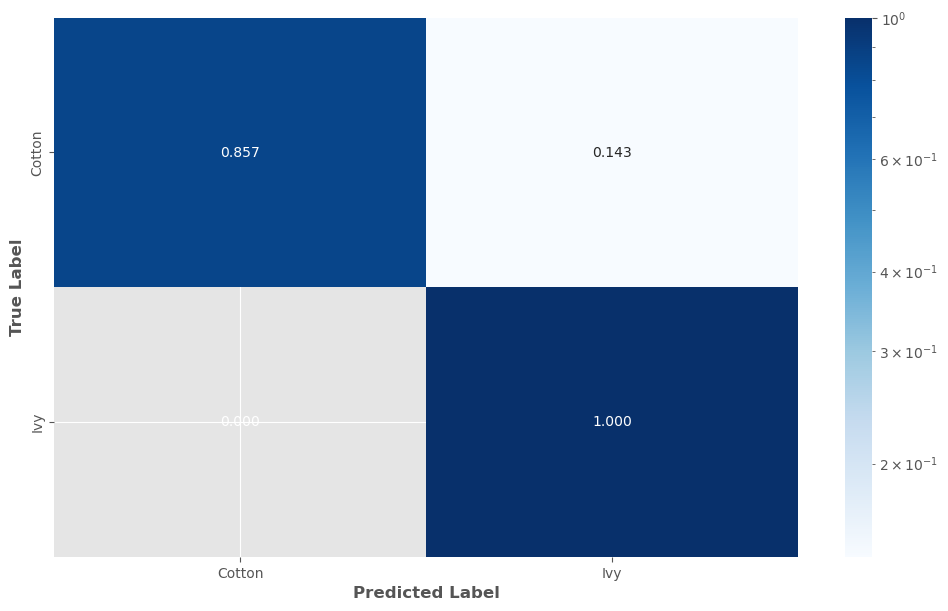

In [12]:
trained_outputs = ect_train_validate(100,100,'example_data/outline_input',log_level=None)
save_model(
    trained_outputs["num_epochs"],
    trained_outputs["model"],
    trained_outputs["optimizer"],
    trained_outputs["lossfcn"]
)
save_plots(
    
    trained_outputs["train_acc"],
    trained_outputs["valid_acc"],
    trained_outputs["train_loss"],
    trained_outputs["valid_loss"],
)
report_trained_model(
    100, 100,
    trained_outputs["train_dataset"],
    trained_outputs["train_loader"],
    trained_outputs["test_loader"],
    trained_outputs["test_dataset"]
)